# 1. Necessary Libraries

In [ ]:
PKG_DIR="/content/drive/MyDrive/offline_packages"

!pip install --no-index --find-links="$PKG_DIR" transformers datasets tokenizers safetensors accelerate evaluate

Looking in links: /content/drive/MyDrive/offline_packages
Processing ./drive/MyDrive/offline_packages/evaluate-0.4.6-py3-none-any.whl


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict

# 2. EDA

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [ ]:
df.isna().sum()

,0
text,0
label,0
label_name,0


In [ ]:
df['label_name'].value_counts()

,count
label_name,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


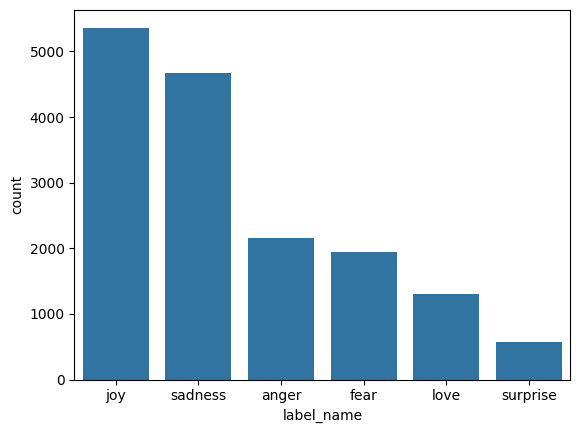

In [ ]:
sns.barplot(x=df['label_name'].value_counts().index,y=df['label_name'].value_counts())
plt.show()

In [ ]:
df['Words Per Tweet'] = df['text'].apply(lambda x:len(x.split()))
df.head()

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


In [ ]:
df.groupby('label_name')['Words Per Tweet'].describe()

,count,mean,std,min,25%,50%,75%,max
label_name,,,,,,,,
anger,2159.0,19.229736,11.426926,2.0,10.0,17.0,26.0,62.0
fear,1937.0,18.844605,10.890188,2.0,10.0,17.0,25.0,60.0
joy,5362.0,19.498135,10.772118,2.0,11.0,18.0,26.0,64.0
love,1304.0,20.700153,10.827956,3.0,12.0,19.0,27.0,63.0
sadness,4666.0,18.361980,11.037223,2.0,10.0,16.0,24.0,66.0
surprise,572.0,19.970280,11.031756,3.0,12.0,18.0,26.0,60.0


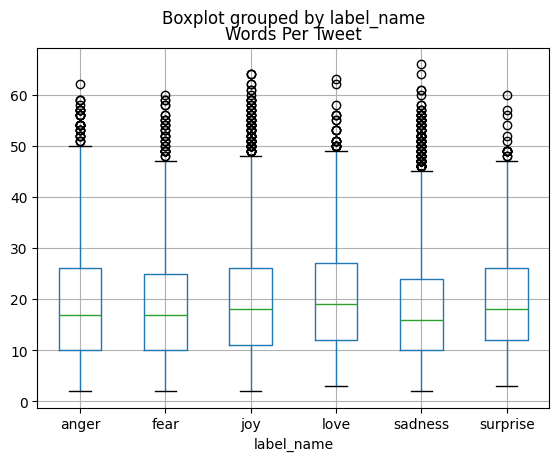

In [ ]:
df.boxplot('Words Per Tweet',by='label_name')
plt.show()

# 3.Stratified Train-test-validation Split

In [ ]:
from sklearn.model_selection import train_test_split

train , test = train_test_split(df,test_size=0.3,random_state=42,stratify=df['label_name'])
test , validation = train_test_split(test,test_size=1/3,random_state=42,stratify=test['label_name'])

print(train.shape)
print(test.shape)
print(validation.shape)

(11200, 4)
(3200, 4)
(1600, 4)


# 4.Conversion to HF Dataset

In [ ]:
dataset = DatasetDict({
    'train':Dataset.from_pandas(train,preserve_index=False),
    'test':Dataset.from_pandas(test,preserve_index=False),
    'validation':Dataset.from_pandas(validation,preserve_index=False)
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words Per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words Per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words Per Tweet'],
        num_rows: 1600
    })
})

# 5.label2id , id2label

In [ ]:
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label
print(id2label)
print(label2id)

{0: 'sadness', 1: 'joy', 4: 'fear', 5: 'surprise', 3: 'anger', 2: 'love'}
{'sadness': 0, 'joy': 1, 'fear': 4, 'surprise': 5, 'anger': 3, 'love': 2}


# 6. Model Selection

In [ ]:
labels = df['label_name'].unique().tolist()
labels

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

In [ ]:
model_dir = '/content/drive/MyDrive/offline_models/bert-base-uncased'

config = AutoConfig.from_pretrained(model_dir,local_files_only=True,id2label=id2label,label2id=label2id,num_classes=len(labels))
tokenizer = AutoTokenizer.from_pretrained(model_dir,local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(model_dir,local_files_only=True,config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/offline_models/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
model.config

BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

# 7. Tokenization

In [ ]:
def tokenize(batch):
  return tokenizer(batch['text'],truncation=True,padding=True,max_length=120)

print(tokenize(dataset['train'][0]))
print(dataset['train'][0])

{'input_ids': [101, 1045, 2514, 12511, 2009, 2003, 2053, 2393, 2005, 2033, 2008, 2060, 5381, 2360, 2008, 1045, 2572, 3407, 2129, 2172, 3606, 2045, 2089, 2022, 1999, 2009, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'text': 'i feel unhappy it is no help for me that other persons say that i am happy how much truth there may be in it', 'label': 0, 'label_name': 'sadness', 'Words Per Tweet': 25}


In [ ]:
tokenized_dataset = dataset.map(tokenize,batched=True,batch_size=None)
tokenized_dataset

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words Per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words Per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words Per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

Removing Other columns to save space

In [ ]:
columns_to_remove = ['text', 'Words Per Tweet']

final_dataset = tokenized_dataset.remove_columns(columns_to_remove)
final_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'label_name', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['label', 'label_name', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['label', 'label_name', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

# 8.Training Arguements

In [ ]:
from transformers import TrainingArguments

batch_size = 64

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    disable_tqdm=False,
)

# 9. Compute Metrics

In [ ]:
import evaluate

accuracy = evaluate.load('accuracy')
f1 = evaluate.load('f1')
precision = evaluate.load('precision')

def compute_metrics_evaluate(eval_pred):
  logits,labels = eval_pred
  preds = np.argmax(logits,axis=-1)
  results ={}
  results['accuracy'] = accuracy.compute(predictions=preds,references=labels)
  results['f1'] = f1.compute(predictions=preds,references=labels,average='weighted')
  results['precision'] = precision.compute(predictions=preds,references=labels,average='weighted')
  return results

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 10. Training

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics_evaluate,
    tokenizer = tokenizer,
    train_dataset = final_dataset['train'],
    eval_dataset = final_dataset['validation']
)

/tmp/ipython-input-2343835500.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pavan220405 (pavan220405-iit-ropar-tif) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision
1,No log,0.334006,{'accuracy': 0.901875},{'f1': 0.8970588701834807},{'precision': 0.9020262374070493}
2,No log,0.182766,{'accuracy': 0.93625},{'f1': 0.9367571042440944},{'precision': 0.9378804654104752}
3,0.484200,0.169274,{'accuracy': 0.9375},{'f1': 0.9385452127879522},{'precision': 0.9420090835759831}


Trainer is attempting to log a value of "{'accuracy': 0.901875}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8970588701834807}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9020262374070493}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.93625}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9367571042440944}" of type <class 'dict'> for key "eval/f

TrainOutput(global_step=525, training_loss=0.4682055818466913, metrics={'train_runtime': 532.6382, 'train_samples_per_second': 63.082, 'train_steps_per_second': 0.986, 'total_flos': 1502253632275200.0, 'train_loss': 0.4682055818466913, 'epoch': 3.0})

# 11. Prediction and Evaluation

In [ ]:
output_preds = trainer.predict(final_dataset['test'])
output_preds.metrics

{'test_loss': 0.19707100093364716,
 'test_accuracy': {'accuracy': 0.925},
 'test_f1': {'f1': 0.9256846783506574},
 'test_precision': {'precision': 0.9271564049129979},
 'test_runtime': 12.9292,
 'test_samples_per_second': 247.502,
 'test_steps_per_second': 3.867}

In [ ]:
print(final_dataset['test']['label'][:])

[3, 0, 4, 1, 3, 3, 1, 1, 1, 0, 5, 1, 0, 1, 3, 0, 0, 1, 0, 0, 0, 4, 5, 2, 4, 3, 4, 0, 1, 3, 0, 4, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 4, 2, 2, 0, 4, 1, 5, 1, 1, 2, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 3, 0, 1, 0, 0, 0, 1, 3, 1, 0, 0, 1, 4, 2, 3, 1, 3, 0, 3, 1, 0, 3, 4, 0, 2, 1, 0, 1, 5, 0, 1, 4, 2, 1, 3, 4, 3, 0, 0, 4, 1, 0, 0, 0, 1, 0, 2, 3, 3, 4, 1, 3, 0, 1, 3, 1, 0, 0, 2, 2, 1, 1, 3, 0, 4, 1, 2, 4, 1, 5, 1, 0, 4, 1, 1, 3, 1, 0, 3, 0, 1, 1, 0, 0, 3, 0, 1, 0, 0, 0, 1, 0, 0, 4, 0, 1, 1, 1, 1, 4, 5, 1, 1, 3, 1, 0, 0, 3, 1, 0, 0, 0, 3, 4, 0, 3, 1, 0, 1, 3, 4, 0, 2, 1, 1, 4, 4, 1, 1, 0, 1, 1, 1, 0, 3, 2, 3, 0, 0, 3, 4, 3, 2, 1, 3, 1, 3, 1, 4, 0, 1, 0, 2, 0, 4, 1, 0, 3, 0, 0, 1, 4, 1, 2, 1, 3, 0, 0, 1, 3, 0, 0, 0, 3, 1, 1, 4, 4, 0, 5, 0, 1, 3, 2, 1, 1, 0, 0, 4, 2, 1, 3, 4, 1, 4, 1, 3, 1, 3, 1, 0, 1, 4, 0, 1, 1, 1, 4, 0, 0, 4, 2, 1, 0, 1, 2, 4, 2, 0, 3, 3, 1, 1, 0, 2, 4, 2, 4, 4, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 3, 1, 0, 0, 2, 1, 0, 0, 4, 1, 2, 1, 1, 5, 3, 0, 

In [ ]:
y_pred = np.argmax(output_preds.predictions,axis=-1)
y_true = final_dataset['test']['label'][:]

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       933
           1       0.96      0.93      0.94      1072
           2       0.81      0.89      0.85       261
           3       0.94      0.92      0.93       432
           4       0.89      0.88      0.89       387
           5       0.74      0.84      0.79       115

    accuracy                           0.93      3200
   macro avg       0.88      0.90      0.89      3200
weighted avg       0.93      0.93      0.93      3200



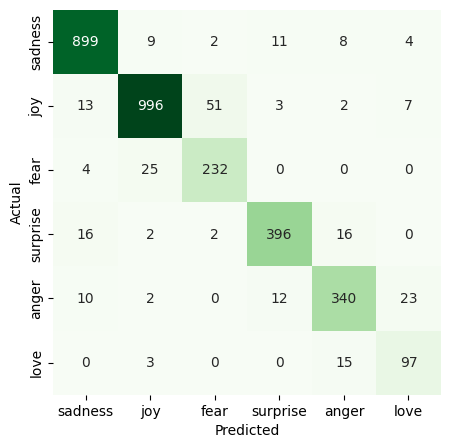

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Greens')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Save the model

In [ ]:
trainer.save_model('/content/drive/MyDrive/offline_models/bert-sentiment-model')

In [ ]:
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/offline_models/bert-sentiment-model',local_files_only=True)
classifier = pipeline('sentiment-analysis',model='/content/drive/MyDrive/offline_models/bert-sentiment-model')

Device set to use cuda:0


In [ ]:
classifier(['hello, how are you?', "love you", "i am feeling low","I am so happy today! Best day ever.",
            "I love this phone — camera is amazing.","I feel empty and alone.","I'm terrified of the exam tomorrow.",
            "This is outrageous! I will never buy from them again.","Well done 👏👏 I'm proud of you!",
            "Honestly, I love and hate this at the same time.","Can't sleep, heart racing, so anxious.",
            "She is my soulmate, forever <3"])

[{'label': 'joy', 'score': 0.7938095927238464},
 {'label': 'love', 'score': 0.7806172966957092},
 {'label': 'sadness', 'score': 0.9862167835235596},
 {'label': 'joy', 'score': 0.9843908548355103},
 {'label': 'surprise', 'score': 0.48596784472465515},
 {'label': 'sadness', 'score': 0.987054169178009},
 {'label': 'fear', 'score': 0.9601675868034363},
 {'label': 'anger', 'score': 0.9373120069503784},
 {'label': 'joy', 'score': 0.9833775758743286},
 {'label': 'anger', 'score': 0.4796634614467621},
 {'label': 'fear', 'score': 0.9555342197418213},
 {'label': 'joy', 'score': 0.7872892618179321}]